In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats#
from numpy import random
from itertools import accumulate

## Import/ Clean Arrival rates

In [2]:
# read the Excel sheet into a pandas dataframe
df_arrival_rate = pd.read_excel("C:/Users/Ramya/Downloads/Copy of probability_data4.xlsx", sheet_name='Load_Factor 1_6')
#
# drop columns
df_arrival_rate.drop('Unnamed: 0', axis=1, inplace=True)

global df_arrival_rate 
df_arrival_rate = df_arrival_rate.transpose().reset_index(drop=True)
df_arrival_rate = df_arrival_rate - 0.025

In [3]:
cumm_rate = np.cumsum(df_arrival_rate, axis = 1)
cumm_rate.head()

,0,1,2,3
0,0.041916,0.131449,0.463601,0.9
1,0.042230,0.132119,0.464143,0.9
2,0.042544,0.132790,0.464687,0.9
3,0.042859,0.133462,0.465232,0.9
4,0.043175,0.134135,0.465777,0.9


## Model Classes

In [6]:
class FlightEnv:
    """
    A class used to represent a single leg flight with overbookings, cancellations
    and no-shows.

    ...

    Attributes
    ----------
    C : int
        capacity of the flight
    
    T : int
        time till departure
    
    beta : int
        probabilty of show up
    
    C_ : int
        overbooking limit
    
    theta : int 
        denied service cost
    
    bookings : int
        number of bookings made
    
    time : int
        current timestep 
    
    accept, reject, cancel : int
        indicators to identify the outcome of the time step

   `reward: float
        reward generated by agents action
    
    fares : array
        represents the possible fare classes
    
    delta : array
        sample cancellation probabilty estimate  by fare class
    
    Delta : array
        adjusted cancellation probailty
    
    cumm_Delta : list
        cummilative cancellation probailty
    
    gamma : array
        refund percentages
        
    actions : list 
        set of all possible actions
        
    state : tuple 
        state space
        
    arrival_rate : dataframe
        arrival probabilty of each fare class at each possible time step
    
    cumm_rate : dataframe
        cummilative arrival probabilty of each fare class at each possible time step
    
    
    Functions
    -------
    resest(self)
        resets the enviournment to default values.
    
    step(self, action)
        simulates a time step in the booking time horizon,based on the on the agents
        action returns the reward, new state, revenue, and outcome of the time step.
    """
    def __init__(self):
        
        
        self.C = 25 # capacity of the flight
        self.T = 149 # time till departure
        
        self.reward = 0 #intialise rewrads
        
        self.fares = [40,30,20,10] # fares for each fare class
        
        #Arrival rate for each fare class , data was downloaded externally. Arrival rates asummed
        #to have a load factor of 1.6. 
        self.arrival_rate = df_arrival_rate 
        self.cumm_rate = np.cumsum(self.arrival_rate, axis = 1) #cummilative arrival probalities
        
        self.beta = 0.9 #probabilty of show up
        self.C_ = int(np.floor(self.C/self.beta)) #overbooking limit
        self.theta = 50 #denied service cost
        
        self.delta = np.array([0.05,0.05,0.1,0.1]) #cancellation probabilty by fare class
        self.Delta = (1-self.beta)*self.delta #actual cancellation probailty
        self.cumm_Delta = list(accumulate(self.Delta)) #cummilative cancellation probailty
        self.gamma = np.array([0.9,0.8,0.7,0.7]) # refund percentages
        
        self.actions = [(0, 1)]*len(self.fares) # actions 0 to reject or 1 to accept booking
        
        self.bookings = 0 # number of bookings
        self.time = 0 # timestep 
        
        # state represented by the number of bookings and time till departure
        self.state = (self.bookings, self.time ) 
        
        #initialise indicators to identify the outcome of the customer request
        self.accept = 0
        self.reject = 0
        self.cancel = 0
    
    
    def reset(self):
        
        """
        Resets the enviournment class
        
        Parameters
        ----------
            enviournment class
        
        Returns
        ------
            reset enviournment class
        
        """
        self.bookings = 0
        self.time = 0
        
        self.state = (self.bookings, self.time)
        return self.state
        
    
    
    def step(self, action):
        
        """
        Simulates a time step in the booking time horizon,based on the on the agents
        action returns the reward, new state, revenue, and outcome of the time step.

        Parameters
        ----------
        enviournment class
        
        action : int
            action taken by the agent

        Returns
        ------
        reward : float
            reward generated by agents action
        
        revenue : float
            revenue genreated by agents action
        
        done : boolean
            returns whether the iteration is terminated or not
        
        state : tuple
            new state as a result of the the agent's action
            
        accept, reject, cancel : int
            indicators to identify the outcome of the time step
        
        """

        
        #increment time step
        self.time += 1
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
        
        self.revenue = 0
        self.reward = 0
        
        # Check if episode is done (if capacity is reached or timestep is greater than or equal to T)
        done = (self.bookings >= self.C_) or (self.time >= self.T)
        
        if done == True: # at time of departure/ or limit reached flight
            
            # penalty for overbooking
            overbookings = np.max([0, np.random.binomial(n=self.bookings, p=self.beta)-self.C])
            self.reward = -1*self.theta * overbookings

            # revenue from bookings minus penalty
            self.revenue = self.reward
       
        else:
            # generate an arrival 
            rv = np.random.rand()
            try:
                fare_class = list(x >= rv for x in self.cumm_rate.iloc[self.time,]).index(True)
            except ValueError:
                # if there are no arrivals
                fare_class = len(self.fares)+1

            # Check whether there is no arrival or not
            if fare_class <= len(self.fares):  # there is an arrival; no arrival is at row 4
               
                # If agent accepts the booking, increase number of bookings and update reward
                if action == self.actions[fare_class][1]:
                    self.bookings += 1
                    self.accept = 1
                    self.reward = self.fares[fare_class]
                    self.revenue = self.fares[fare_class]
                    
                # If agent rejects the booking, update reward 
                else :
                    self.reward = -10*((self.C-self.bookings)/np.exp(0.5*(self.T-self.time)))
                    self.reject = 1
       
            elif (self.bookings > 0) and(fare_class > len(self.fares)): #as set by ValueError
                # Select a random fare class
                rv = np.random.rand()
                fare_index = list(x >= rv for x in self.cumm_Delta)
                cancel_fare_class = next((i for i, x in enumerate(fare_index) if x), len(fare_index))


                # Check whether there is a cancellation or not
                if cancel_fare_class < len(self.fares): 
                    self.bookings -= 1
                    self.reward = -1*self.fares[cancel_fare_class]*self.gamma[cancel_fare_class]
                    self.revenue = self.reward
                    self.cancel = 1
            else:
                # no-arrival, no cancellation
                self.reward = 0


            # Update state
            self.state = (self.bookings, self.time)

        
            
        # Return state, reward, done, and revenue
        return self.state, self.reward, done, self.revenue, self.accept, self.reject, self.cancel

In [7]:
class QLearningAgent:
     """
    A class used to train the agent. Agent will select actions based on the Q-table and 
    update the Q-table based on the outcome of its action.
    ...

    Attributes
    ----------
    env: class
        flight enviournment class
    q_table: matrix
        table containing the Q-values of all possible states
    
    Functions
    -------
    get_action(self,state)
        resets the enviournment to default values.
    
    update_q_table(self, state, action, reward, next_sate)
        simulates a time step in the booking time horizon,based on the on the agents
        action returns the reward, new state, revenue, and outcome of the time step.
    """
    
    def __init__(self, env):
        self.q_table = {} # Q table to store the values
        self.C_ = env.C_ #Overbooking limit of the flight
        self.T = env.T # time till departure
        self.actions = env.actions
        self.action_size = len(self.actions)*2 # number of actions

        # Initialise Q matrix with all 0 entries
        for i in range(self.C_ + 1):
            for j in range(self.T + 1):
                self.q_table[(i, j)] = [0 for _ in range(self.action_size)]

    def get_action(self, state):
        """
        Choses the action to take based on the current state. Agent primarily choses the best action based on the Q-values but
        the agent may explore random staregies based on the exploration parameter.
        
        Parameters
        ----------
            enviournment class
            
            state : tuple
                current state of the flight enviournment
        
        Returns
        ------
            action to take: int
                0 to reject customer and 1 to accept the customer
            
        
        """
        epsilon = 0.68211 # exploration parameter

        # Take random choice
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_size)

        # Chose best value based on Q-matrix
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        """
        Updates the Q_table based on the results of the agents action.
        
        Parameters
        ----------
            enviournment class
            
            state : tuple
                current state of the flight enviournment
            action: int
                action taken by the agent
            reward: float
                reward generated by agent's action
            next_state :tuple
                next sate as a result of the agent's action
        
        Updates
        ------
            q_table : matrix
                table containing the Q-values of all possible states
            
        
        """
        gamma = 0.958293 #discountfactor
        alpha = 0.321033 #learning rate


        # reward that is max based on current q-matrix
        next_max_q = max(self.q_table[next_state])

        self.q_table[state][action] =  self.q_table[state][action] + alpha * (reward + gamma * next_max_q-self.q_table[state][action])
        
    def return_q_table(self):
        return self.q_table


## Model Implementation

In [9]:
num_iter = 100000 #number of iterations

#initialise classes
env = FlightEnv()
agent = QLearningAgent(env)

#create empty lists to catch data
iteration_ls =[]
reward_ls = []
revenue_ls = []
accepted_ls =[]
rejected_ls = []
cancellation_ls = []


for iteration in range(num_iter):
    state = env.reset()
    done = False
    iteration_ls.append(iteration)
    
    #Intialise varaiables at each iteration
    total_reward = 0
    total_revenue = 0
    total_accepted = 0
    total_rejected = 0
    total_cancellation = 0
    
    #while the terminal state is not reached
    while not done:
        #get agent action
        action = agent.get_action(state, episode)
        
        # get results of the agent's action
        next_state, reward, done, revenue, accept, reject, cancel = env.step(action)
        
        #update q-table based on results of the agent's action
        agent.update_q_table(state, action, reward, next_state)
        
        #update current state
        state = next_state
        
        #append variables
        total_reward += reward
        total_revenue += revenue
        total_accepted += accept
        total_rejected += reject
        total_cancellation += cancel

    #Append lists after terminal state reached
    revenue_ls.append(total_revenue)
    reward_ls.append(total_reward)
    rejected_ls.append(total_rejected)
    accepted_ls.append(total_accepted)
    cancellation_ls.append(total_cancellation)
    

In [10]:
#store reults as a dataframe
df_Reward = pd.DataFrame({"Iteration": iteration_ls, "Reward": reward_ls,'Revenue':revenue_ls,'Accepted':accepted_ls,
                          'Rejected':rejected_ls,'Cancellations':cancellation_ls})


In [11]:
df_Reward.tail()

,Episode,Reward,Revenue,Accepted,Rejected,Cancellations
99995,99995,547.255987,540.0,27,103,0
99996,99996,410.001899,410.0,27,97,0
99997,99997,380.000000,380.0,27,77,0
99998,99998,433.000442,433.0,28,88,1
99999,99999,356.703422,356.0,28,97,1


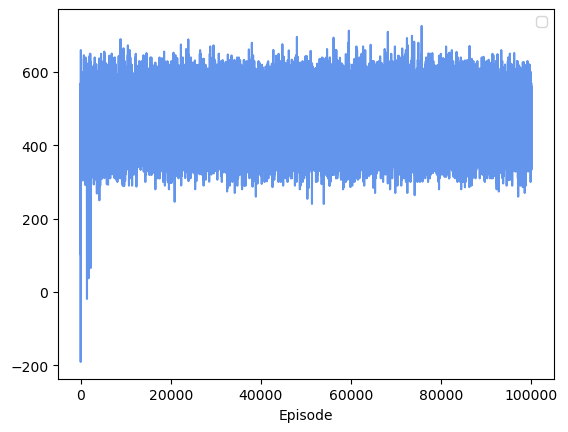

In [12]:
df_Reward.plot(x="Episode", y="Reward", kind="line",color = 'cornflowerblue')

plt.legend(())

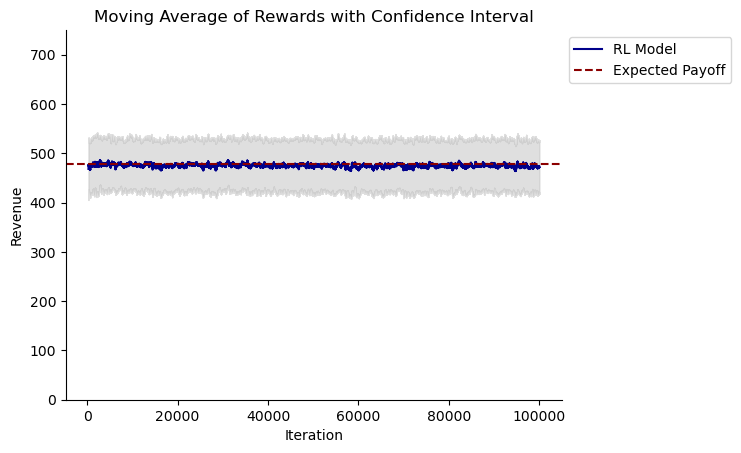

In [38]:
# calculate simple moving average with a window size of 10
sma = df_Reward['Revenue'].rolling(window=300).mean()
df_Reward['sma'] = sma

# calculate standard deviation of the simple moving average
std = df_Reward['Revenue'].rolling(window=300).std()

# calculate upper and lower bounds of the confidence interval
upper_bound = sma + std
lower_bound = sma - std

# plot moving average and confidence interval for RL model
sns.lineplot(data=df_Reward, x="Episode", y=sma, color='darkblue', label='RL Model')
plt.fill_between(df_Reward["Episode"], upper_bound, lower_bound, alpha=0.5, color='#C0C0C0')

# # calculate simple moving average and add Naive model
# sma_NM = df_reward_NM['Revenue'].rolling(window=10).mean()
# sns.lineplot(data=df_reward_NM, x="Episode", y=sma_NM, color='#F15854', alpha=0.5, label='Naive Model')

# add horizontal line with label at Expected Revenue
plt.axhline(y=477.93791, color='darkred', linestyle='--', label='Expected Payoff')


# set x and y axis labels
plt.xlabel('Iteration')
plt.ylabel('Revenue')

# set plot title
plt.title('Moving Average of Rewards with Confidence Interval')

plt.ylim(0, 750)

# add legend and remove top and right spines
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
sns.despine()

plt.savefig('SMA_Revenue_by_model.png', transparent=True)

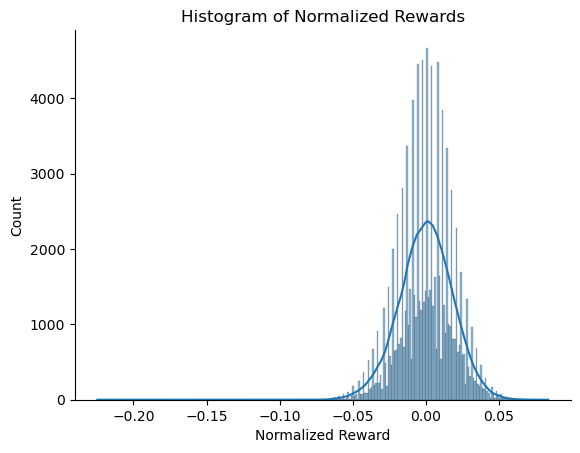

In [44]:
sns.histplot(data=df_Reward, x=(df_Reward['Reward']-df_Reward['Reward'].mean())/df_Reward['Reward'].std()**2,
             kde=True)
# set x and y axis labels
plt.xlabel('Normalized Reward')
plt.ylabel('Count')

# set plot title
plt.title('Histogram of Normalized Rewards')

# remove top and right spines
sns.despine()

plt.show()

#plt.savefig('Normalised_reward.png', transparent=True)

## Bayesian Optimisation

In [13]:
class QLearningAgentBayes:
    def __init__(self, env, epsilon,alpha, gamma):
        self.q_table = {} # Q table to store the values
        self.C_ = env.C_ #Overbooking limit of the flight
        self.T = env.T # time till departure
        self.actions = env.actions
        self.action_size = len(self.actions)*2 # number of actions
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

        # Initialise Q matrix with all 0 entries
        for i in range(self.C_ + 1):
            for j in range(self.T + 1):
                self.q_table[(i, j)] = [0 for _ in range(self.action_size)]

    def get_action(self, state, episode):
        #epsilon = 0.99/(episode+1) # exploration parameter

        # Take random choice
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)

        # Chose best value based on Q-matrix
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
#         gamma = 0.99 # discount factor
#         alpha = 0.9 # learning rate

        # reward that is max based on current q-matrix
        next_max_q = max(self.q_table[next_state])

        self.q_table[state][action] = (1 - self.alpha) * self.q_table[state][action] + self.alpha * (reward + self.gamma * next_max_q)
        
    def return_q_table(self):
        return self.q_table


In [7]:
!pip install colorama==0.4.4

  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.6
    Uninstalling colorama-0.4.6:
      Successfully uninstalled colorama-0.4.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylint 2.14.5 requires colorama>=0.4.5; sys_platform == "win32", but you have colorama 0.4.4 which is incompatible.
bayesian-optimization 1.4.2 requires colorama>=0.4.6, but you have colorama 0.4.4 which is incompatible.


In [8]:
!pip install bayesian-optimization

  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Attempting uninstall: colorama
    Found existing installation: colorama 0.4.4
    Uninstalling colorama-0.4.4:
      Successfully uninstalled colorama-0.4.4


In [ ]:
#!conda install -c conda-forge bayesian-optimization

In [316]:
from bayes_opt import BayesianOptimization

# Define the search space for hyperparameters
pbounds = {'alpha': (0, 1), 'gamma': (0, 1), 'epsilon': (0, 1)}

In [19]:
def objective(epsilon,alpha, gamma):
    num_episodes =1000
    env = FlightEnv()
    agent = QLearningAgentBayes(env,epsilon,alpha, gamma)
    

    
    reward_ls = np.array([])
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        rejected = 0
        
        while not done:
            action = agent.get_action(state, episode)
            next_state, reward, done, revenue, a, r, c = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            
        reward_ls =  np.append(reward_ls,total_reward)

    return reward_ls.mean()

In [405]:
# Create an instance of BayesianOptimization class
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

# Specify the number of iterations for Bayesian optimization
num_iterations = 15
optimizer.maximize(
    init_points= 5,
    n_iter=num_iterations ,
)

|   iter    |  target   |   alpha   |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | 321.3     | 0.3745    | 0.9507    | 0.732     |
| 2         | 449.5     | 0.5987    | 0.156     | 0.156     |
| 3         | 458.3     | 0.05808   | 0.8662    | 0.6011    |
| 4         | 448.5     | 0.7081    | 0.02058   | 0.9699    |
| 5         | 453.1     | 0.8324    | 0.2123    | 0.1818    |
| 6         | 453.1     | 0.7058    | 0.198     | 0.2883    |
| 7         | 463.5     | 0.04481   | 0.8313    | 0.5832    |
| 8         | 152.3     | 0.0       | 0.9154    | 0.2049    |
| 9         | -23.5     | 0.0       | 0.5966    | 0.8316    |
| 10        | 446.7     | 0.7802    | 0.01741   | 0.6307    |
| 11        | 460.6     | 0.926     | 0.262     | 0.834     |
| 12        | 456.5     | 0.9924    | 0.3086    | 0.5187    |
| 13        | 458.3     | 0.6804    | 0.3995    | 0.6738    |
| 14        | 459.5     | 0.7961    | 0.5773    | 0.3165    |
| 15    

In [408]:
# Print the best hyperparameters found
print(optimizer.max)

{'target': 467.4620134629697, 'params': {'alpha': 0.9838036674368149, 'epsilon': 0.6505141477798516, 'gamma': 0.6776036755092681}}


In [ ]:
#max
# alpha = 0.321033
# gamma = 0.958293
# epsilon = 0.68211

#min
# alpha = 0.0327638
# gamma = 0.550996
# epsilon = 0.89916

#average
# alpha = 0.9838
# gamma = 0.6776
# epsilon = 0.6505



## Parameter Sensitivity

In [224]:
class FlightEnv:
    def __init__(self):
        self.C = 50 # capacity of the flight
        self.T = 50 # time till departure
        
        self.reward = 0 
        
        self.fares = [40,30,20,10] # fares for each fare class
        self.arrival_rate = df_arrival_rate.sample(n = 50) # arrival rate for each fare class
        self.cumm_rate = np.cumsum(self.arrival_rate, axis = 1) #cummilative arrival probalities
        
        self.beta = 0.9 #probabilty of show up
        self.C_ = int(np.floor(self.C/self.beta)) # Overbooking limit
        self.theta = 50 # denied service cost
        
        self.delta = np.array([0.05,0.05,0.1,0.1]) #  Cancellation probabilty by fare class
        self.alpha = (1-self.beta)*self.delta # Actual cancellation probailty
        self.cumm_alpha = list(accumulate(self.alpha))
        self.gamma = np.array([0.9,0.8,0.7,0.7]) # refund percentages
        
        self.actions = [(0, 1)]*len(self.fares) # actions t0 reject or accept booking
        
        self.state = (0, 0) # state represented by number of bookings and time till departure
        self.bookings = 0 # number of bookings
        self.time_till_departure = 0 # time till departure
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
    
    
    def reset(self):
        self.bookings = 0
        self.time_till_departure = 0
        
        self.state = (self.bookings, self.time_till_departure)
        return self.state
        
    
    
    def step(self, action):
        #global reward
        # Increment time till departure
        self.time_till_departure += 1
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
        
        self.revenue = 0
        self.reward = 0
        
        # Check if episode is done (if capacity is reached or time till departure is greater than T)
        done = (self.bookings >= self.C_) or (self.time_till_departure >= self.T)
        
        if done == True: # at time of departure/ or limit reached flight
            
            # penalty for overbooking
            overbookings = np.max([0, np.random.binomial(n=self.bookings, p=self.beta)-self.C])
            self.reward = -1*self.theta * overbookings

            # revenue from bookings minus penalty
            self.revenue = -1*self.theta * overbookings
       
        else:
            # generate an arrival 
            rv = np.random.rand()
            try:
                fare_class = list(x >= rv for x in self.cumm_rate.iloc[self.time_till_departure,]).index(True)
            except ValueError:
                # Handle the error here, for example by setting fare_class to a default value
                fare_class = len(self.fares)+1

            # Check whether there is no arrival or not
            if fare_class < len(self.fares):  # there is an arrival; no arrival is at row 4
                # If agent accepts the booking, increase number of bookings and update reward
                if action == self.actions[fare_class][1]:
                    self.bookings += 1
                    self.accept = 1
                    self.reward = self.fares[fare_class]
                    self.revenue = self.reward
                    #print('booked!')


                # If agent rejects the booking, update reward to 0
                else :
                    self.reward = -10*((self.C-self.bookings)/np.exp(0.5*(self.T-self.time_till_departure)))
                    self.reject = 1
       
            elif (self.bookings > 0) and(fare_class > len(self.fares)):# there is no arrival; no arrival is at row 4  
                # Select a random fare class
                rv = np.random.rand()
                fare_index = list(x >= rv for x in self.cumm_alpha)
                cancel_fare_class = next((i for i, x in enumerate(fare_index) if x), len(fare_index))


                    # Check whether there is no arrival or not
                if cancel_fare_class < len(self.fares):  # there is a cancellation; no cancellation is at row 4

                    self.bookings -= 1
                    self.reward = -1*self.fares[cancel_fare_class]*self.gamma[cancel_fare_class]
                    self.revenue = self.reward
            
                    self.cancel = 1
                    #print('cancelled!')
            else:
                # no-arrival, no cancellation
                self.reward = 0


            # Update state
            self.state = (self.bookings, self.time_till_departure)

        
            
        # Return state, reward, done, and revenue
        return self.state, self.reward, done, self.revenue, self.accept, self.reject, self.cancel

In [225]:
num_episodes = 10000

env = FlightEnv()
agent = QLearningAgent(env)

episode_ls =[]
reward_ls = []
revenue_ls = []
accepted_ls =[]
rejected_ls = []
cancellation_ls = []


for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_ls.append(episode)
    total_reward = 0
    
    total_revenue = 0
    total_accepted = 0
    total_rejected = 0
    total_cancellation = 0
    
    
    while not done:
        action = agent.get_action(state, episode)

        next_state, reward, done, revenue, accept, reject, cancel = env.step(action)
        agent.update_q_table(state, action, reward, next_state)
        
        state = next_state
        
        total_reward += reward
        total_revenue += revenue
        total_accepted += accept
        total_rejected += reject
        total_cancellation += cancel


    revenue_ls.append(total_revenue)
    reward_ls.append(total_reward)
    
    rejected_ls.append(total_rejected)
    accepted_ls.append(total_accepted)
    cancellation_ls.append(total_cancellation)
    

In [226]:
df_Reward = pd.DataFrame({"Episode": episode_ls, "Reward": reward_ls,'Revenue':revenue_ls,'Accepted':accepted_ls,
                          'Rejected':rejected_ls,'Cancellations':cancellation_ls})

In [227]:
df_Reward.tail()

,Episode,Reward,Revenue,Accepted,Rejected,Cancellations
9995,9995,-988.034322,200.0,9,34,0
9996,9996,-1054.120573,250.0,15,30,0
9997,9997,-820.015549,230.0,12,33,0
9998,9998,-606.126509,320.0,16,27,0
9999,9999,-573.025065,290.0,19,30,0


In [228]:
(df_Reward.Revenue.mean()/25)/40

0.28612650000000006

In [157]:
model_order=['base','low_T','high_C','high_f','high_delta','high_omega','full_refund','naive']

In [158]:
#create empty lists to catch needed metrics
# Avg_Rev_ls = []
# Avg_load_ls = []
# Rej_percentage_ls = []
# Avg_cancellation_ls = []
# Avg_overbooking_ls = []


In [229]:
# Manual adjustment/ runs  as required

Avg_Rev_ls.append((df_Reward.Revenue.mean()/50)/40) # as apropotion of max fare class

Avg_load_ls.append(df_Reward.Accepted.mean()/50)

Rej_percentage_ls.append(df_Reward.Rejected.sum()/(df_Reward.Accepted.sum()+df_Reward.Rejected.sum()))

Avg_cancellation_ls.append(df_Reward.Cancellations.mean()/50)

Avg_overbooking_ls.append((df_Reward.Accepted.mean()-50))


In [230]:
Avg_Rev_ls

[0.4774755,
 0.4122706,
 0.32418749999999996,
 0.30748836,
 0.4777401,
 0.47626369999999996,
 0.476591,
 0.14306325000000003]

In [231]:
df_Sensitivity = pd.DataFrame({"Model": model_order, "Avg. Normalised Revenue": Avg_Rev_ls,'Avg. Load':Avg_load_ls,
                               'Percentage Rejected' :Rej_percentage_ls,'Avg. Cancellation':Avg_cancellation_ls,
                               'Avg. Overbooking':Avg_overbooking_ls})

In [232]:
df_Sensitivity

,Model,Avg. Normalised Revenue,Avg. Load,Percentage Rejected,Avg. Cancellation,Avg. Overbooking
0,base,0.477475,1.084264,0.769403,0.015280,2.1066
1,low_T,0.412271,0.905264,0.742571,0.011308,-2.3684
2,high_C,0.324187,0.704008,0.735778,0.008450,-14.7996
3,high_f,0.307488,1.060944,0.787070,0.016156,1.5236
4,high_delta,0.477740,1.096636,0.769656,0.030444,2.4159
5,high_omega,0.476264,1.082556,0.771782,0.015092,2.0639
6,full_refund,0.476591,1.084520,0.768583,0.014960,2.1130
7,naive,0.143063,0.311504,0.646750,0.002762,-34.4248


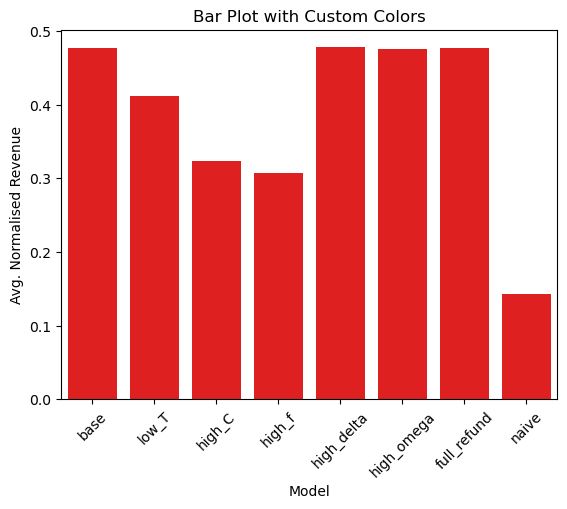

In [244]:
# Create a bar plot with custom colors
sns.barplot(x='Model', y='Avg. Normalised Revenue', data= df_Sensitivity, color='red')

# Add plot labels and title
plt.xlabel('Model')
plt.ylabel('Avg. Normalised Revenue')
plt.title('Bar Plot with Custom Colors')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()

In [243]:
df_Sensitivity.to_excel('sensitivity.xlsx', index=False)

## Effects of Oppotunity Cost

In [274]:
class FlightEnvP:
    def __init__(self):
        self.C = 25 # capacity of the flight
        self.T = 149 # time till departure
        
        self.reward = 0 
        
        self.fares = [40,30,20,10] # fares for each fare class
        self.arrival_rate = df_arrival_rate # arrival rate for each fare class
        self.cumm_rate = np.cumsum(self.arrival_rate, axis = 1) #cummilative arrival probalities
        
        self.beta = 0.9 #probabilty of show up
        self.C_ = int(np.floor(self.C/self.beta)) # Overbooking limit
        self.theta = 50 # denied service cost
        
        self.delta = np.array([0.05,0.05,0.1,0.1]) #  Cancellation probabilty by fare class
        self.alpha = (1-self.beta)*self.delta # Actual cancellation probailty
        self.cumm_alpha = list(accumulate(self.alpha))
        self.gamma = np.array([0.9,0.8,0.7,0.7]) # refund percentages
        
        self.actions = [(0, 1)]*len(self.fares) # actions t0 reject or accept booking
        
        self.state = (0, 0) # state represented by number of bookings and time till departure
        self.bookings = 0 # number of bookings
        self.time_till_departure = 0 # time till departure
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
    
    
    def reset(self):
        self.bookings = 0
        self.time_till_departure = 0
        
        self.state = (self.bookings, self.time_till_departure)
        return self.state
        
    
    
    def step(self, action):
        #global reward
        # Increment time till departure
        self.time_till_departure += 1
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
        
        self.revenue = 0
        self.reward = 0
        
        # Check if episode is done (if capacity is reached or time till departure is greater than T)
        done = (self.bookings >= self.C_) or (self.time_till_departure >= self.T)
        
        if done == True: # at time of departure/ or limit reached flight
            
            # penalty for overbooking
            overbookings = np.max([0, np.random.binomial(n=self.bookings, p=self.beta)-self.C])
            self.reward = -1*self.theta * overbookings

            # revenue from bookings minus penalty
            self.revenue = -1*self.theta * overbookings
       
        else:
            # generate an arrival 
            rv = np.random.rand()
            try:
                fare_class = list(x >= rv for x in self.cumm_rate.iloc[self.time_till_departure,]).index(True)
            except ValueError:
                # Handle the error here, for example by setting fare_class to a default value
                fare_class = len(self.fares)+1

            # Check whether there is no arrival or not
            if fare_class < len(self.fares):  # there is an arrival; no arrival is at row 4
                # If agent accepts the booking, increase number of bookings and update reward
                if action == self.actions[fare_class][1]:
                    self.bookings += 1
                    self.accept = 1
                    self.reward = self.fares[fare_class]
                    self.revenue = self.reward
                    #print('booked!')


                # If agent rejects the booking, update reward to 0
                else :
                    self.reward = -10*((self.C-self.bookings)/np.exp(0.5*(self.T-self.time_till_departure)))
                    self.reject = 1
       
            elif (self.bookings > 0) and(fare_class > len(self.fares)):# there is no arrival; no arrival is at row 4  
                # Select a random fare class
                rv = np.random.rand()
                fare_index = list(x >= rv for x in self.cumm_alpha)
                cancel_fare_class = next((i for i, x in enumerate(fare_index) if x), len(fare_index))


                    # Check whether there is no arrival or not
                if cancel_fare_class < len(self.fares):  # there is a cancellation; no cancellation is at row 4

                    self.bookings -= 1
                    self.reward = -1*self.fares[cancel_fare_class]*self.gamma[cancel_fare_class]
                    self.revenue = self.reward
            
                    self.cancel = 1
                    #print('cancelled!')
            else:
                # no-arrival, no cancellation
                self.reward = 0


            # Update state
            self.state = (self.bookings, self.time_till_departure)

        
            
        # Return state, reward, done, and revenue
        return self.state, self.reward, done, self.revenue, self.accept, self.reject, self.cancel

In [288]:
class FlightEnvNP:
    def __init__(self):
        self.C = 25 # capacity of the flight
        self.T = 149 # time till departure
        
        self.reward = 0 
        
        self.fares = [40,30,20,10] # fares for each fare class
        self.arrival_rate = df_arrival_rate # arrival rate for each fare class
        self.cumm_rate = np.cumsum(self.arrival_rate, axis = 1) #cummilative arrival probalities
        
        self.beta = 0.9 #probabilty of show up
        self.C_ = int(np.floor(self.C/self.beta)) # Overbooking limit
        self.theta = 50 # denied service cost
        
        self.delta = np.array([0.05,0.05,0.1,0.1]) #  Cancellation probabilty by fare class
        self.alpha = (1-self.beta)*self.delta # Actual cancellation probailty
        self.cumm_alpha = list(accumulate(self.alpha))
        self.gamma = np.array([0.9,0.8,0.7,0.7]) # refund percentages
        
        self.actions = [(0, 1)]*len(self.fares) # actions t0 reject or accept booking
        
        self.state = (0, 0) # state represented by number of bookings and time till departure
        self.bookings = 0 # number of bookings
        self.time_till_departure = 0 # time till departure
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
    
    
    def reset(self):
        self.bookings = 0
        self.time_till_departure = 0
        
        self.state = (self.bookings, self.time_till_departure)
        return self.state
        
    
    
    def step(self, action):
        #global reward
        # Increment time till departure
        self.time_till_departure += 1
        
        self.accept = 0
        self.reject = 0
        self.cancel = 0
        
        self.revenue = 0
        self.reward = 0
        
        # Check if episode is done (if capacity is reached or time till departure is greater than T)
        done = (self.bookings >= self.C_) or (self.time_till_departure >= self.T)
        
        if done == True: # at time of departure/ or limit reached flight
            
            # penalty for overbooking
            overbookings = np.max([0, np.random.binomial(n=self.bookings, p=self.beta)-self.C])
            self.reward = -1*self.theta * overbookings

            # revenue from bookings minus penalty
            self.revenue = -1*self.theta * overbookings
       
        else:
            # generate an arrival 
            rv = np.random.rand()
            try:
                fare_class = list(x >= rv for x in self.cumm_rate.iloc[self.time_till_departure,]).index(True)
            except ValueError:
                # Handle the error here, for example by setting fare_class to a default value
                fare_class = len(self.fares)+1

            # Check whether there is no arrival or not
            if fare_class < len(self.fares):  # there is an arrival; no arrival is at row 4
                # If agent accepts the booking, increase number of bookings and update reward
                if action == self.actions[fare_class][1]:
                    self.bookings += 1
                    self.accept = 1
                    self.reward = self.fares[fare_class]
                    self.revenue = self.reward
                    #print('booked!')


                # If agent rejects the booking, update reward to 0
                else :
                    self.reward = -10
                    self.reject = 1
       
            elif (self.bookings > 0) and(fare_class > len(self.fares)):# there is no arrival; no arrival is at row 4  
                # Select a random fare class
                rv = np.random.rand()
                fare_index = list(x >= rv for x in self.cumm_alpha)
                cancel_fare_class = next((i for i, x in enumerate(fare_index) if x), len(fare_index))


                    # Check whether there is no arrival or not
                if cancel_fare_class < len(self.fares):  # there is a cancellation; no cancellation is at row 4

                    self.bookings -= 1
                    self.reward = -1*self.fares[cancel_fare_class]*self.gamma[cancel_fare_class]
                    self.revenue = self.reward
            
                    self.cancel = 1
                    #print('cancelled!')
            else:
                # no-arrival, no cancellation
                self.reward = 0


            # Update state
            self.state = (self.bookings, self.time_till_departure)

        
            
        # Return state, reward, done, and revenue
        return self.state, self.reward, done, self.revenue, self.accept, self.reject, self.cancel

In [289]:
num_episodes = 10000

env = FlightEnvNP()
agent = QLearningAgent(env)

episode_ls =[]
reward_ls = []
revenue_ls = []
accepted_ls =[]
rejected_ls = []
cancellation_ls = []


for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_ls.append(episode)
    total_reward = 0
    
    total_revenue = 0
    total_accepted = 0
    total_rejected = 0
    total_cancellation = 0
    
    
    while not done:
        action = agent.get_action(state, episode)

        next_state, reward, done, revenue, accept, reject, cancel = env.step(action)
        agent.update_q_table(state, action, reward, next_state)
        
        state = next_state
        
        total_reward += reward
        total_revenue += revenue
        total_accepted += accept
        total_rejected += reject
        total_cancellation += cancel


    revenue_ls.append(total_revenue)
    reward_ls.append(total_reward)
    
    rejected_ls.append(total_rejected)
    accepted_ls.append(total_accepted)
    cancellation_ls.append(total_cancellation)
    

In [290]:
df_Reward= pd.DataFrame({"Episode": episode_ls, "Reward": reward_ls,'Revenue':revenue_ls,'Accepted':accepted_ls,
                          'Rejected':rejected_ls,'Cancellations':cancellation_ls})

In [291]:
model_order=['Penalty','No Penalty','Minus Penalty']
#create empty lists to catch needed metrics

In [279]:
#create empty lists to catch needed metrics
Avg_Rev_ls = []
Avg_load_ls = []
Rej_percentage_ls = []
Avg_cancellation_ls = []
Avg_overbooking_ls = []


In [292]:
# Manual adjustment/ runs  as required

Avg_Rev_ls.append((df_Reward.Revenue.mean()/25)) # as apropotion of max fare class

Avg_load_ls.append(df_Reward.Accepted.mean()/25)

Rej_percentage_ls.append(df_Reward.Rejected.sum()/(df_Reward.Accepted.sum()+df_Reward.Rejected.sum()))

Avg_cancellation_ls.append(df_Reward.Cancellations.mean()/25)

Avg_overbooking_ls.append((df_Reward.Accepted.mean()-25))


In [293]:
df_Penalty = pd.DataFrame({"Model": model_order, "Avg. Normalised Revenue": Avg_Rev_ls,'Avg. Load':Avg_load_ls,
                               'Percentage Rejected' :Rej_percentage_ls,'Avg. Cancellation':Avg_cancellation_ls,
                               'Avg. Overbooking':Avg_overbooking_ls})

In [294]:
df_Penalty.head()

,Model,Avg. Normalised Revenue,Avg. Load,Percentage Rejected,Avg. Cancellation,Avg. Overbooking
0,Penalty,19.096120,1.085556,0.766463,0.014732,2.1389
1,No Penalty,19.072388,1.079060,0.776089,0.015188,1.9765
2,Minus Penalty,18.725696,1.088808,0.653776,0.009708,2.2202


In [257]:
df_Reward_NP = pd.DataFrame({"Episode": episode_ls, "Reward": reward_ls,'Revenue':revenue_ls,'Accepted':accepted_ls,
                          'Rejected':rejected_ls,'Cancellations':cancellation_ls})

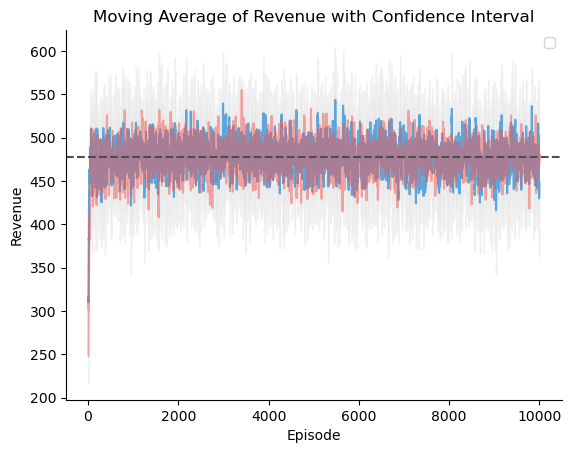

In [258]:
# calculate simple moving average with a window size of 10
sma = df_Reward_penalty['Revenue'].rolling(window=10).mean()
df_Reward_penalty['sma'] = sma

# calculate standard deviation of the simple moving average
std = df_Reward_penalty['Revenue'].rolling(window=10).std()

# calculate upper and lower bounds of the confidence interval
upper_bound = sma + std
lower_bound = sma - std

# plot moving average and confidence interval for RL model
sns.lineplot(data=df_Reward_penalty, x="Episode", y=sma, color='#5DA5DA', label='Model with penalty')
plt.fill_between(df_Reward["Episode"], upper_bound, lower_bound, alpha=0.2, color='#C0C0C0')

# calculate simple moving average and add Naive model
sma_NP = df_Reward_NP['Revenue'].rolling(window=10).mean()
sns.lineplot(data=df_Reward_NP, x="Episode", y=sma_NP, color='#F15854', alpha=0.5, label='Model without penalty')

# add horizontal line with label at Expected Revenue
plt.axhline(y=477.93791, color='#4D4D4D', linestyle='--', label='Expected Payoff per period x Capacity')


# set x and y axis labels
plt.xlabel('Episode')
plt.ylabel('Revenue')

# set plot title
plt.title('Moving Average of Revenue with Confidence Interval')

# add legend and remove top and right spines
plt.legend([])
sns.despine()

#plt.savefig('SMA_Revenue_by_model.png', transparent=True)

In [262]:
df_Reward_NP.Accepted.mean()/25

1.078848

In [263]:
df_Reward_penalty.Accepted.mean()/25

1.08314

In [260]:
df_Reward_NP.tail()

,Episode,Reward,Revenue,Accepted,Rejected,Cancellations
9995,9995,430.0,430.0,25,109,0
9996,9996,500.0,500.0,27,88,0
9997,9997,510.0,510.0,27,106,0
9998,9998,430.0,430.0,27,101,0
9999,9999,460.0,460.0,26,114,0


In [261]:
df_Reward_penalty.tail()

,Episode,Reward,Revenue,Accepted,Rejected,Cancellations,sma
9995,9995,463.392472,450.0,26,105,0,432.5
9996,9996,430.000598,430.0,27,86,0,442.5
9997,9997,360.011919,360.0,27,92,0,435.5
9998,9998,490.005109,490.0,27,91,0,446.5
9999,9999,490.022895,490.0,27,93,0,448.2
